In [1]:
import cv2
import pickle
from PIL import Image
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [2]:
with open("./normal.pickle", "rb") as f:
    normal_hash = pickle.load(f)
    
with open("./normal_faces.pickle", "rb") as f:
    normal_faces = pickle.load(f)
    
alp_uv = loadmat("./UV_Processed.mat")

with open("./parts_list_ids.pickle", "rb") as f:
    parts_list_ids = pickle.load(f)
    
with open("./atlas_hash.pickle", "rb") as f:
    atlas_hash = pickle.load(f)
    
with open("normal2atlas_512_200.pickle", mode='rb') as f:
    mapping_relation = pickle.load(f)

In [3]:
normal_tex = transforms.ToTensor()(Image.open("./normal_texture_1.jpg"))

In [4]:
normal_tex_batch = torch.stack([normal_tex, normal_tex])
normal_tex_batch.shape

torch.Size([2, 3, 512, 512])

In [5]:
bs, c, h, w = normal_tex_batch.shape
print(bs, c, h, w)

2 3 512 512


In [6]:
atlas_size = 200

In [7]:
vertex_tex = {}

In [8]:
for k, v in normal_hash.items():
    vertex_tex[k] = normal_tex_batch[:, :, int(h - v[0][1] * (h-1)), int(v[0][0] * (w - 1))]

In [9]:
FaceIndices = alp_uv["All_FaceIndices"].squeeze()
FacesDensePose = alp_uv["All_Faces"] - 1
U_norm = alp_uv["All_U_norm"].squeeze()
V_norm = alp_uv["All_V_norm"].squeeze()
All_vertices = alp_uv["All_vertices"][0]

In [10]:
# parts_list_ids = {}
# for parts_num in range(1, 25):
#     FaceIndicesNow = np.where(FaceIndices == parts_num)
#     FacesNow = FacesDensePose[FaceIndicesNow]
#     parts_list_id = np.unique(FacesNow.flatten())
#     parts_list_ids[parts_num] = parts_list_id
# with open("./parts_list_ids.pickle", "wb") as f:
#     pickle.dump(parts_list_ids, f)

In [11]:
# atlas_hash = {}
# for parts_num in range(1, 25):
#     parts_list_id = parts_list_ids[parts_num]
#     for u, v, ver in zip(
#         list(U_norm[parts_list_id]),
#         list(V_norm[parts_list_id]),
#         list(All_vertices[parts_list_id])):
#         if (ver - 1) in atlas_hash:
#             atlas_hash[ver - 1].append([parts_num, u, v])
#         else:
#             atlas_hash[ver - 1] = [[parts_num, u, v]]
# with open("./atlas_hash.pickle", "wb") as f:
#     pickle.dump(atlas_hash, f)

In [12]:
def mapping_to_each_atlas_parts(vertex_tex, parts_num):
    """
    Function to convert normal texture into each part of atlas texture.
    params:
    vertex_tex: Stores the texture for each point of the SMPL model.
    parts_num: The number of the parts. 1 ~ 24.
    """
    tex = torch.zeros((bs, c, atlas_size, atlas_size))

    for k, v in atlas_hash.items():
        for t in v:
            if  t [ 0 ] ==  parts_num :
                tex[:, :, int(t[1] * (atlas_size - 1)), (atlas_size - 1) -
                    int(t[2] * (atlas_size - 1))] = vertex_tex[k]

    return tex / 255

In [13]:
atlas_texture = torch.zeros((24, bs, c, atlas_size, atlas_size))
for  i  in  range (24):
    atlas_texture[i] = mapping_to_each_atlas_parts(vertex_tex, parts_num=i + 1)

In [14]:
atlas_texture.shape

torch.Size([24, 2, 3, 200, 200])

In [15]:
mapping_relation[500000]

[66, 69, 3, 461, 443]

In [16]:
len(mapping_relation)

835485

In [17]:
normal_tex_batch.shape

torch.Size([2, 3, 512, 512])

In [18]:
painted_atlas_tex = atlas_texture.clone()
# painted_atlas_tex = painted_atlas_tex.transpose(0, 1)
# for relation in mapping_relation:
#     new_tex = normal_tex_batch[:, :, relation[3], relation[4]]
#     painted_atlas_tex[:,relation[2], :, relation[0], relation[1]]
for relation in mapping_relation:
    new_tex = normal_tex_batch[:, :, relation[3], relation[4]]
    painted_atlas_tex[relation[2], :, :, relation[0], relation[1]]  = new_tex / 255

In [19]:
painted_atlas_tex.shape

torch.Size([24, 2, 3, 200, 200])

### now putting the texture on a densepose

In [20]:
target_image = transforms.ToTensor()(transforms.Resize((512, 512))((Image.open("./human.jpg"))))
target_image1 = transforms.ToTensor()(transforms.Resize((512, 512))((Image.open("./human1.jpg"))))

In [21]:
target_image_batch = torch.stack([target_image, target_image1])
target_image_batch.shape

torch.Size([2, 3, 512, 512])

In [22]:
target_dense = np.load("./dense.npy")
target_dense = np.moveaxis(target_dense, 0, -1)
target_dense = cv2.resize(target_dense, dsize=(512, 512), interpolation = cv2.INTER_NEAREST)

target_dense1 = np.load("./dense1.npy")
target_dense1 = np.moveaxis(target_dense1, 0, -1)
target_dense1 = cv2.resize(target_dense1, dsize=(512, 512), interpolation = cv2.INTER_NEAREST)

In [23]:
target_dense = torch.from_numpy(target_dense)
target_dense1 = torch.from_numpy(target_dense1)
target_dense_batch = torch.stack([target_dense, target_dense1])
# target_dense_batch = target_dense_batch.permute(0, 3, 1, 2)
target_dense_batch.shape

torch.Size([2, 512, 512, 3])

In [24]:
target_dense_clone = target_dense_batch.clone()

In [44]:
target_dense_scatter_U = torch.zeros(25, bs, 512, 512).scatter_(0, target_dense_clone[:,:,:,0].unsqueeze(0).long(), target_dense_clone[:,:,:,1].unsqueeze(0))
target_dense_scatter_V = torch.zeros(25, bs, 512, 512).scatter_(0, target_dense_clone[:,:,:,0].unsqueeze(0).long(), target_dense_clone[:,:,:,2].unsqueeze(0))


target_dense_U = target_dense_clone[:,:,:,1].unsqueeze(0)
target_dense_U = target_dense_U.repeat(25, 1, 1, 1)

target_dense_V = target_dense_clone[:,:,:,2].unsqueeze(0)
target_dense_V = target_dense_V.repeat(25, 1, 1, 1)

target_dense_scatter_U[target_dense_scatter_U != 0] = 1
target_dense_scatter_V[target_dense_scatter_V != 0] = 1

target_dense_scatter_U = target_dense_scatter_U * target_dense_U
target_dense_scatter_V = target_dense_scatter_V * target_dense_V


target_dense_scatter_U = target_dense_scatter_U.permute(1, 0, 2, 3)
target_dense_scatter_V = target_dense_scatter_V.permute(1, 0, 2, 3)


target_dense_scatter_U = target_dense_scatter_U * 199./255.
target_dense_scatter_V = (255-target_dense_scatter_V)*199./255.

target_dense_scatter_U = target_dense_scatter_U.unsqueeze(2)
target_dense_scatter_U = target_dense_scatter_U.repeat(1, 1, 3, 1, 1)
target_dense_scatter_V = target_dense_scatter_V.unsqueeze(2)
target_dense_scatter_V = target_dense_scatter_V.repeat(1, 1, 3, 1, 1)

target_dense_scatter_U = target_dense_scatter_U[:,1:,:,:,:].long()
target_dense_scatter_V = target_dense_scatter_V[:,1:,:,:,:].long()

print(target_dense_scatter_U.shape, target_dense_scatter_V.shape)


torch.Size([2, 24, 3, 512, 512]) torch.Size([2, 24, 3, 512, 512])


In [33]:
painted_atlas_tex_clone = painted_atlas_tex.clone()
painted_atlas_tex_clone = painted_atlas_tex_clone.permute(1, 0, 2, 3, 4)*255
painted_atlas_tex_clone = painted_atlas_tex_clone
painted_atlas_tex_clone.shape

torch.Size([2, 24, 3, 200, 200])

In [48]:
print(np.unique(target_dense_scatter_U))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


In [45]:
painted_atlas_on_dense = painted_atlas_tex_clone.reshape(144, 200, 200)[torch.arange(144).repeat_interleave(262144), target_dense_scatter_U.reshape(37748736), target_dense_scatter_V.reshape(37748736)]

In [ ]:
painted_atlas_on_dense = painted_atlas_on_dense.reshape(2, 24, 3, 512, 512)
painted_atlas_on_dense.shape

In [82]:
painted_atlas_on_dense = painted_atlas_on_dense.permute(0, 2, 1, 3, 4)

In [83]:
painted_atlas_on_dense.shape

torch.Size([2, 3, 24, 512, 512])

In [84]:
painted_atlas_on_dense_summed = torch.sum(painted_atlas_on_dense, 2)

In [85]:
painted_atlas_on_dense_summed.shape

torch.Size([2, 3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


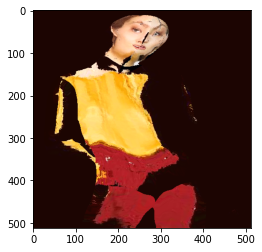

In [86]:
plt.imshow(painted_atlas_on_dense_summed[1].permute(1, 2, 0).numpy())

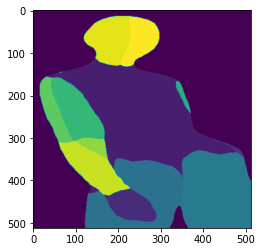

In [51]:
plt.imshow(target_dense_batch[0,:,:,0].numpy())